<a href="https://colab.research.google.com/github/TanOnRush/DSRP/blob/main/DSRP_NASA_Meteorite_Landings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DSRP: NASA Meteorite Landings**

This notebook explores a comprehensive dataset from **The Meteoritical Society**, detailing all known meteorite landings across the globe. The data was originally curated in a Fusion Table by **Javier de la Torre** and is also available as an XLS file.

The dataset includes **34,513 meteorite entries**, with the following key attributes:

- `place`: Location name of the meteorite landing
- `type_of_meteorite`: Classification of the meteorite
- `mass_g`: Mass of the meteorite in grams
- `fell_found`: Whether it was observed falling or later found
- `year`: Year of the landing or discovery
- `database`: Source database identifier
- `coordinate_1` / `coordinates_2`: Original coordinate values
- `cartodb_id`: CartoDB record ID
- `created_at` / `updated_at`: Timestamps for record creation and modification
- `year_date`: Full date reference
- `longitude` / `latitude`: Geographic coordinates
- `geojson`: GeoJSON representation for mapping purposes

[Dataset](https://data.nasa.gov/dataset/meteorite-landings) |
[Project Guide](https://docs.google.com/document/d/1s9s_jMi1Dyn21nLuOzUVnksSAA7MIJD8lD3z7uhz_uc/edit?tab=t.0)

## **Research Question:** How does geographic region (e.g., continent or hemisphere) influence the likelihood of meteorite discoveries, and can we predict future findings based on location?

In [137]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import RandomOverSampler

# Importing the dataset
url = "https://data.nasa.gov/docs/legacy/meteorite_landings/Meteorite_Landings.csv"
nasa_df = pd.read_csv(url)

In [138]:
# Previewing the datasets
nasa_df

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775, 6.08333)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.18333, 10.23333)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.21667, -113.0)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.88333, -99.9)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.16667, -64.95)"
...,...,...,...,...,...,...,...,...,...,...
45711,Zillah 002,31356,Valid,Eucrite,172.0,Found,1990.0,29.03700,17.01850,"(29.037, 17.0185)"
45712,Zinder,30409,Valid,"Pallasite, ungrouped",46.0,Found,1999.0,13.78333,8.96667,"(13.78333, 8.96667)"
45713,Zlin,30410,Valid,H4,3.3,Found,1939.0,49.25000,17.66667,"(49.25, 17.66667)"
45714,Zubkovsky,31357,Valid,L6,2167.0,Found,2003.0,49.78917,41.50460,"(49.78917, 41.5046)"


In [139]:
# Viewing info
nasa_df.info()
nasa_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45716 non-null  object 
 1   id           45716 non-null  int64  
 2   nametype     45716 non-null  object 
 3   recclass     45716 non-null  object 
 4   mass (g)     45585 non-null  float64
 5   fall         45716 non-null  object 
 6   year         45425 non-null  float64
 7   reclat       38401 non-null  float64
 8   reclong      38401 non-null  float64
 9   GeoLocation  38401 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.5+ MB


,id,mass (g),year,reclat,reclong
count,45716.000000,4.558500e+04,45425.000000,38401.000000,38401.000000
mean,26889.735104,1.327808e+04,1991.828817,-39.122580,61.074319
std,16860.683030,5.749889e+05,25.052766,46.378511,80.647298
min,1.000000,0.000000e+00,860.000000,-87.366670,-165.433330
25%,12688.750000,7.200000e+00,1987.000000,-76.714240,0.000000
50%,24261.500000,3.260000e+01,1998.000000,-71.500000,35.666670
75%,40656.750000,2.026000e+02,2003.000000,0.000000,157.166670
max,57458.000000,6.000000e+07,2101.000000,81.166670,354.473330


In [140]:
# Checking the count of null values
null_counts = nasa_df.isnull().sum()
print(null_counts)
null_percent = nasa_df.isnull().mean() * 100
print(null_percent)

name              0
id                0
nametype          0
recclass          0
mass (g)        131
fall              0
year            291
reclat         7315
reclong        7315
GeoLocation    7315
dtype: int64
name            0.000000
id              0.000000
nametype        0.000000
recclass        0.000000
mass (g)        0.286552
fall            0.000000
year            0.636539
reclat         16.000962
reclong        16.000962
GeoLocation    16.000962
dtype: float64


In [141]:
# Converting reclat and reclong to numeric
nasa_df['reclat'] = pd.to_numeric(nasa_df['reclat'], errors='coerce')
nasa_df['reclong'] = pd.to_numeric(nasa_df['reclong'], errors='coerce')

# Dropping the rows with missing and invalid coordinates
nasa_df = nasa_df.dropna(subset=['reclat', 'reclong'])

# Filtering out the entries where both lat and long are 0.0
nasa_df = nasa_df[
    (nasa_df['reclat'] != 0.0) & (nasa_df['reclong'] != 0.0)
].dropna(subset=['reclat', 'reclong']).copy()

Geographic distribution plot saved as meteorite_geographic_distribution.png


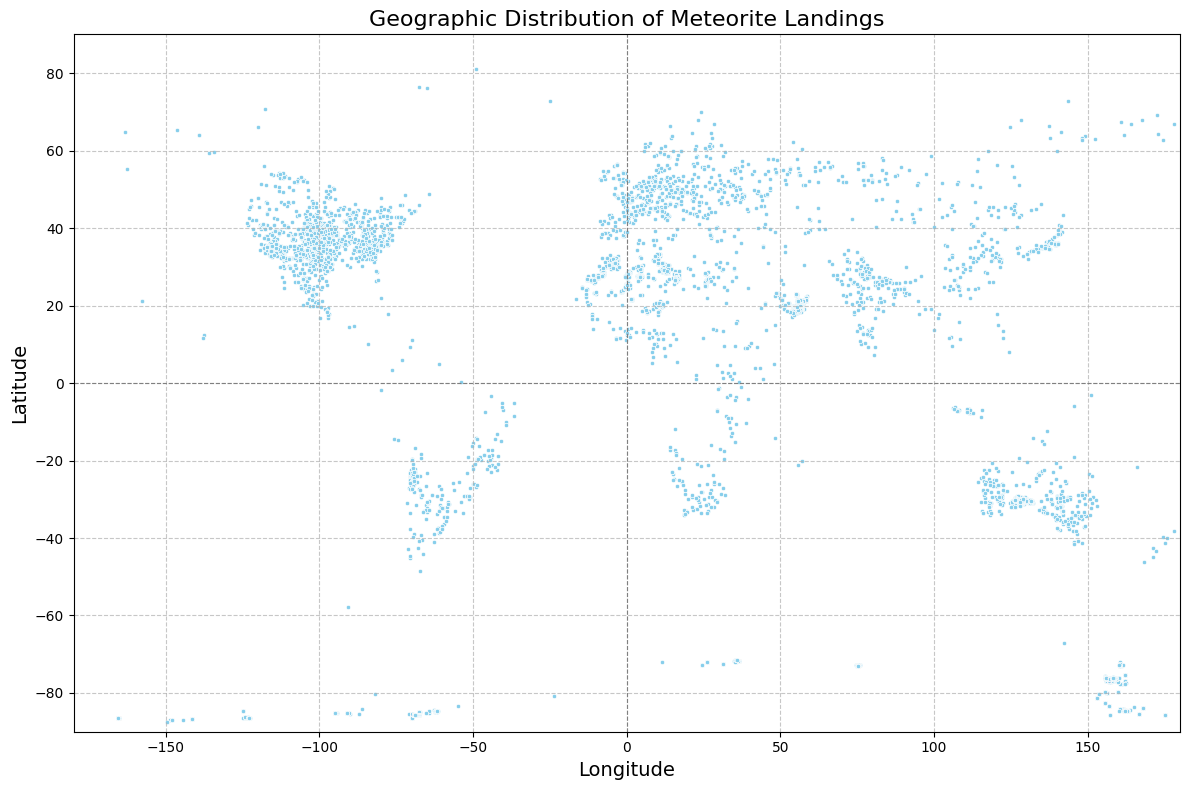

In [142]:
# Visualization
plt.figure(figsize=(12,8))

# Scatter plot
sns.scatterplot(
    x='reclong',
    y='reclat',
    data=nasa_df,
    s=10, #Marker size
    color='skyblue',
    edgecolor='w',
    linewidth=0.5
)

plt.title('Geographic Distribution of Meteorite Landings', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

# Setting limits for latitude and longitude to represent a global map
plt.xlim(-180, 180)
plt.ylim(-90, 90)

plt.grid(True, linestyle='--', alpha=0.7) # Add a grid
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8) # Equator
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8) # Prime Meridian

plt.tight_layout() # Adjust layout to prevent labels from overlapping

# Save the plot
plt.savefig('meteorite_geographic_distribution.png')
print("Geographic distribution plot saved as meteorite_geographic_distribution.png")

# Display the plot
plt.show()

In [143]:
nasa_df = nasa_df.rename(columns = {'mass (g)':'mass_g'})

col1_nulls = nasa_df['mass_g'].isnull()
print(col1_nulls)

0        False
1        False
2        False
3        False
4        False
         ...  
45711    False
45712    False
45713    False
45714    False
45715    False
Name: mass_g, Length: 31963, dtype: bool


In [144]:
# Dropping null values for mass
nasa_df_cleaned_mass = nasa_df.dropna(subset=['mass_g'])
mass_null_count = nasa_df['mass_g'].isnull().sum()
mass_null_count_df1 = nasa_df_cleaned_mass['mass_g'].isnull().sum()
print(mass_null_count)
print(mass_null_count_df1)

# Same with year
nasa_df_cleaned_year = nasa_df.dropna(subset=['year'])
year_null_count = nasa_df['year'].isnull().sum()
year_null_count_df1 = nasa_df_cleaned_year['year'].isnull().sum()
print(year_null_count)
print(year_null_count_df1)

119
0
150
0


In [145]:
# Classification for Northern v. Southern Hemisphere
def class_hemisp_ns(latitude):
  if latitude>0:
    return 'Northern'
  else:
    return 'Southern'

# Applying the function to create a new column
nasa_df['hemisphere_ns'] = nasa_df['reclat'].apply(class_hemisp_ns)


# Classification for Eastern v. Western Hemisphere
def class_hemisp_ew(longitude):
  if longitude >0:
    return 'Eastern'
  else:
    return 'Western'

# Applying the function to create a new column
nasa_df['hemisphere_ew'] = nasa_df['reclong'].apply(class_hemisp_ew)

print(nasa_df[['name', 'reclat', 'reclong', 'hemisphere_ns', 'hemisphere_ew']].head())

       name    reclat    reclong hemisphere_ns hemisphere_ew
0    Aachen  50.77500    6.08333      Northern       Eastern
1    Aarhus  56.18333   10.23333      Northern       Eastern
2      Abee  54.21667 -113.00000      Northern       Western
3  Acapulco  16.88333  -99.90000      Northern       Western
4   Achiras -33.16667  -64.95000      Southern       Western


In [146]:
# Counting the number of meteorites in the hemispheres
ns_count = nasa_df['hemisphere_ns'].value_counts()
ew_count = nasa_df['hemisphere_ew'].value_counts()

print(ns_count)
print(ew_count)

hemisphere_ns
Southern    23413
Northern     8550
Name: count, dtype: int64
hemisphere_ew
Eastern    27911
Western     4052
Name: count, dtype: int64


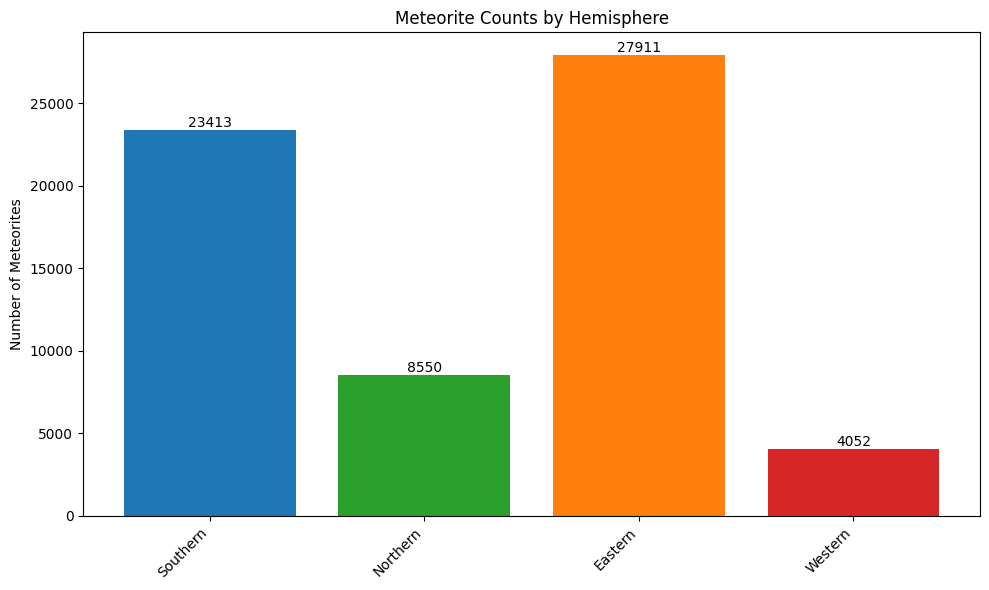

In [147]:
# Combining them for plotting
combined_counts = pd.concat([ns_count, ew_count])

# Visualising
labels = combined_counts.index.tolist()
counts = combined_counts.values.tolist()

bar_colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, counts, color=bar_colors)

plt.ylabel('Number of Meteorites')
plt.title('Meteorite Counts by Hemisphere')
plt.xticks(rotation=45, ha='right')
plt.bar_label(bars)

plt.tight_layout()
plt.savefig('meteorite_hemisphere_counts.png')

In [148]:
ns_fall_counts = pd.crosstab(nasa_df['hemisphere_ns'], nasa_df['fall'])
print("Fell vs. Found counts by Northern/Southern Hemisphere:")
print(ns_fall_counts)
print("\n")

ew_fall_counts = pd.crosstab(nasa_df['hemisphere_ew'], nasa_df['fall'])
print("Fell vs. Found counts by Eastern/Western Hemisphere:")
print(ew_fall_counts)

Fell vs. Found counts by Northern/Southern Hemisphere:
fall           Fell  Found
hemisphere_ns             
Northern        962   7588
Southern        133  23280


Fell vs. Found counts by Eastern/Western Hemisphere:
fall           Fell  Found
hemisphere_ew             
Eastern         777  27134
Western         318   3734


In [158]:
# Cleaned the mass null values
nasa_df_cleaned_mass = nasa_df.dropna(subset=['mass_g'])


stats_ns = nasa_df_cleaned_mass.groupby('hemisphere_ns')['mass_g'].agg(['mean', 'median', 'std'])
stats_ew = nasa_df_cleaned_mass.groupby('hemisphere_ew')['mass_g'].agg(['mean', 'median', 'std'])

header = "Hemisphere       Mean Mass (g)  Median Mass (g)  Standard Deviation (g)"
print(header)

for index, row in stats_ns.iterrows():
    print(f"{index:<16}{row['mean']:.2f}{row['median']:>16.2f}{row['std']:>24.2f}")

print("\n" + "="*len(header) + "\n")
print("By Eastern/Western Hemisphere:")
print(header)

for index, row in stats_ew.iterrows():
    print(f"{index:<16}{row['mean']:.2f}{row['median']:>16.2f}{row['std']:>24.2f}")


Hemisphere       Mean Mass (g)  Median Mass (g)  Standard Deviation (g)
Northern        41617.84          378.00               925851.76
Southern        10352.44           14.90               577966.72


By Eastern/Western Hemisphere:
Hemisphere       Mean Mass (g)  Median Mass (g)  Standard Deviation (g)
Eastern         10155.28           24.27               490083.37
Western         77286.33          249.73              1441219.75


In [150]:
# Chi-Square Test
chi2_nasa = nasa_df.dropna(subset=['fall'])

ns_contingency_table = pd.crosstab(chi2_nasa['hemisphere_ns'], chi2_nasa['fall'])
print("Contingency Table for Northern/Southern Hemisphere:")
print(ns_contingency_table)
print("\n" + "="*80 + "\n")

chi2_ns, p_ns, dof_ns, expected_ns = chi2_contingency(ns_contingency_table)

print("Chi-Square Test Results for Northern/Southern Hemisphere:")
print(f"Chi-Square Statistic: {chi2_ns:.4f}")
print(f"p-value: {p_ns:.4f}")
print(f"Degrees of Freedom: {dof_ns}")
print("\n" + "="*80 + "\n")

ew_contingency_table = pd.crosstab(chi2_nasa['hemisphere_ew'], chi2_nasa['fall'])
print("Contingency Table for Eastern/Western Hemisphere:")
print(ew_contingency_table)
print("\n" + "="*80 + "\n")

chi2_ew, p_ew, dof_ew, expected_ew = chi2_contingency(ew_contingency_table)

print("Chi-Square Test Results for Eastern/Western Hemisphere:")
print(f"Chi-Square Statistic: {chi2_ew:.4f}")
print(f"p-value: {p_ew:.4f}")
print(f"Degrees of Freedom: {dof_ew}")

Contingency Table for Northern/Southern Hemisphere:
fall           Fell  Found
hemisphere_ns             
Northern        962   7588
Southern        133  23280


Chi-Square Test Results for Northern/Southern Hemisphere:
Chi-Square Statistic: 2157.3364
p-value: 0.0000
Degrees of Freedom: 1


Contingency Table for Eastern/Western Hemisphere:
fall           Fell  Found
hemisphere_ew             
Eastern         777  27134
Western         318   3734


Chi-Square Test Results for Eastern/Western Hemisphere:
Chi-Square Statistic: 272.7419
p-value: 0.0000
Degrees of Freedom: 1


There is a relationship between a meterotie's `fall` type and whether it's found in the Northern or Southern Hemisphere. They are not independent variables. Same with the East & West. Both are highly statistically significant.

the Southern Hemisphere (which includes Antarctica) is a uniquely effective location for finding meteorites that were not observed falling. It discovers environment there is fundamentally different.

The Eastern Hemisphere is a more prolific region for meteorite discovery, which points to the influence of specific landmasses and the effectiveness of searching there.

From the result, it is determined that geographic region has a significant influence on the likelihood of meteorite discoveries. The high proportion of 'Found' meteorites in the Southern and Eastern hemispheres.

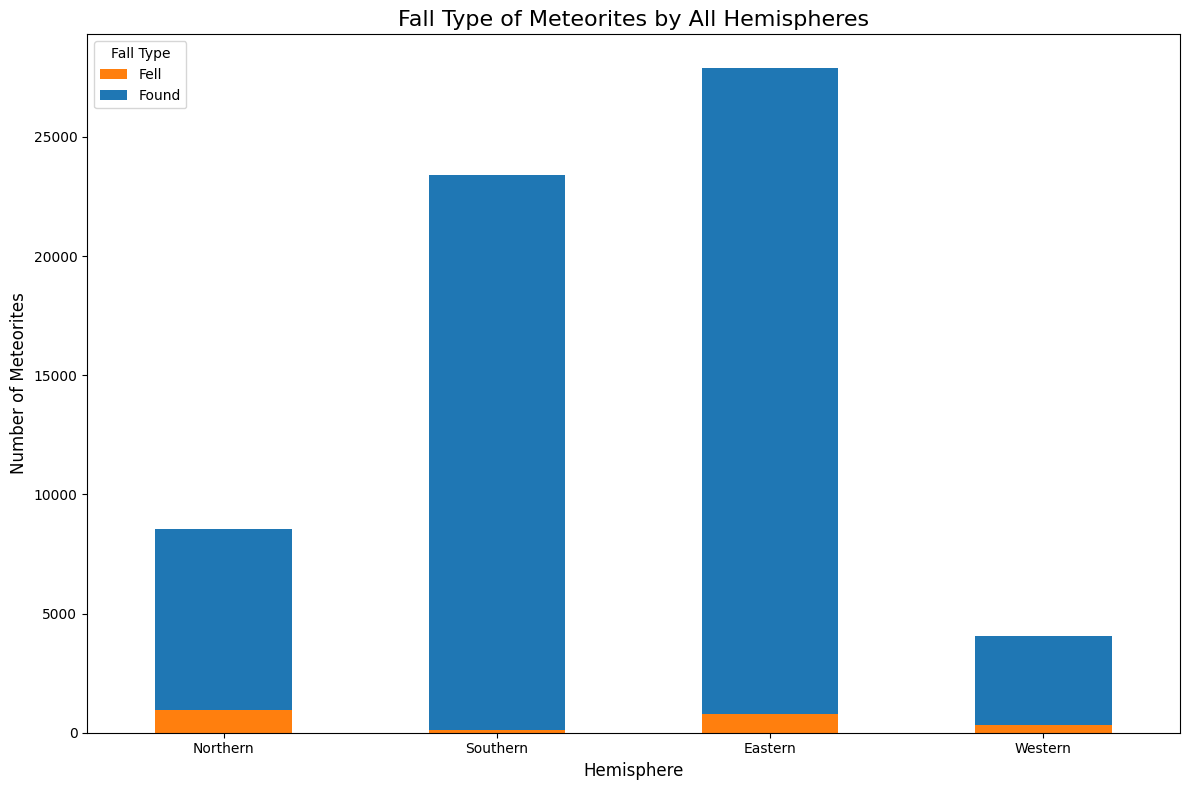

In [151]:
# Visualizing the result
nasa_df.dropna(subset=['fall'], inplace=True)

ns_table = pd.crosstab(nasa_df['hemisphere_ns'], nasa_df['fall'])
ew_table = pd.crosstab(nasa_df['hemisphere_ew'], nasa_df['fall'])
all_hemispheres_table = pd.concat([ns_table, ew_table])

fig, ax = plt.subplots(figsize=(12, 8))

all_hemispheres_table.plot(kind='bar', stacked=True, ax=ax, color={'Fell': '#ff7f0e', 'Found': '#1f77b4'})

ax.set_title('Fall Type of Meteorites by All Hemispheres', fontsize=16)
ax.set_xlabel('Hemisphere', fontsize=12)
ax.set_ylabel('Number of Meteorites', fontsize=12)

plt.xticks(rotation=0)

ax.legend(title='Fall Type', loc='upper left')

plt.tight_layout()
plt.savefig('fall_type_by_all_hemispheres_stacked_bar.png')
plt.show()

In [152]:
# KNN Model 1
# Recleaning the data
nasa_df.dropna(subset=['reclat', 'reclong', 'fall'], inplace=True)

# KNN Model Prediction

nasa_df['fall_encoded'] = nasa_df['fall'].map({'Fell': 0, 'Found': 1})

X = nasa_df[['reclat', 'reclong']]
y = nasa_df['fall_encoded']

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training the model
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_scaled, y_train)

# Evaluating the model's performance
y_pred = model.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Fell', 'Found']))

print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Showing the model's predictions
print("\n Example Predictions:")

sample_data = X_test.head()
sample_data_scaled = scaler.transform(sample_data)
sample_predictions = model.predict(sample_data_scaled)

for i in range(len(sample_data)):
    prediction_label = 'Found' if sample_predictions[i] == 1 else 'Fell'
    actual_label = 'Found' if y_test.iloc[i] == 1 else 'Fell'
    print(f"Location: ({sample_data.iloc[i]['reclat']:.2f}, {sample_data.iloc[i]['reclong']:.2f})")
    print(f"Predicted Fall Type: {prediction_label}, Actual Fall Type: {actual_label}")
    print("-" * 20)

Classification Report:
              precision    recall  f1-score   support

        Fell       0.73      0.64      0.68       206
       Found       0.99      0.99      0.99      6187

    accuracy                           0.98      6393
   macro avg       0.86      0.82      0.84      6393
weighted avg       0.98      0.98      0.98      6393

Overall Accuracy: 0.98

 Example Predictions:
Location: (-72.98, 75.27)
Predicted Fall Type: Found, Actual Fall Type: Found
--------------------
Location: (28.68, 13.42)
Predicted Fall Type: Found, Actual Fall Type: Found
--------------------
Location: (-79.68, 159.75)
Predicted Fall Type: Found, Actual Fall Type: Found
--------------------
Location: (-72.00, 26.00)
Predicted Fall Type: Found, Actual Fall Type: Found
--------------------
Location: (21.06, 57.30)
Predicted Fall Type: Found, Actual Fall Type: Found
--------------------


- The model mistakenly predicted a 'Found' meteorite as a 'Fell'one.
- It missed about 34% of the real 'Fell' meteorites and misclassifying them as 'Found'.
- The model is almost perfect at predicting 'Found' meteorites. This is because there are so many of them that the model rarely gets it wrong.

In [157]:
# KNN Model 2

nasa_df['fall_encoded'] = nasa_df['fall'].map({'Fell': 0, 'Found': 1})

X = nasa_df[['reclat', 'reclong']]
y = nasa_df['fall_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

print("Class distribution after oversampling:")
print(pd.Series(y_train_resampled).value_counts())
print("\n" + "="*80 + "\n")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_scaled, y_train_resampled)

y_pred = model.predict(X_test_scaled)

print("--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Fell', 'Found']))

print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Class distribution after oversampling:
fall_encoded
1    24681
0    24681
Name: count, dtype: int64


--- Classification Report ---
              precision    recall  f1-score   support

        Fell       0.57      0.84      0.68       206
       Found       0.99      0.98      0.99      6187

    accuracy                           0.97      6393
   macro avg       0.78      0.91      0.83      6393
weighted avg       0.98      0.97      0.98      6393

Overall Accuracy: 0.97


- The `recall` for the 'Fell' class was 0.66, but in the second model it becomes 0.85. Which is an improvement.
- The `precision` for the 'Fell' class dropped from 0.72 to 0.58. <-- False positives
- No longer biased towards the majority class.
- Makes a bit more false positive errors.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


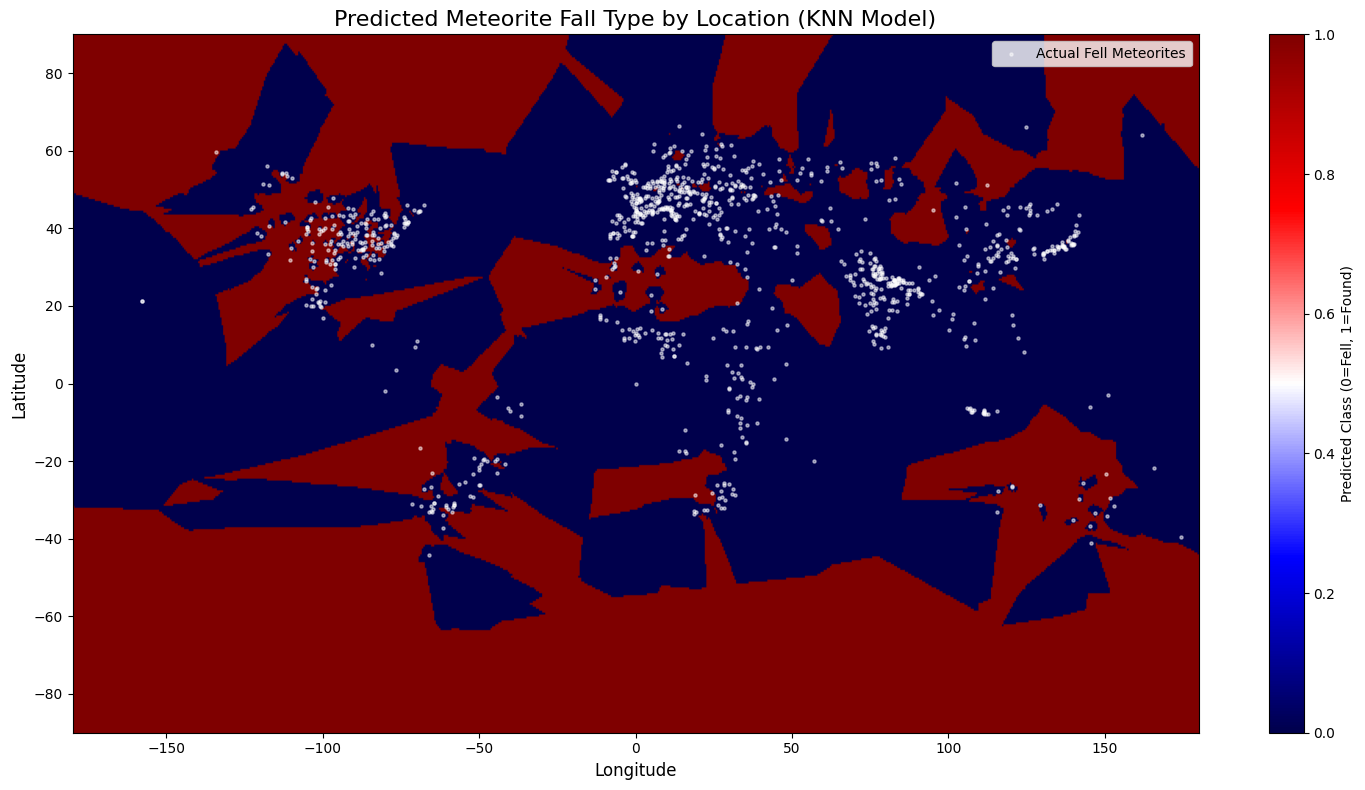

In [156]:
# Training the KNN Model to generate a heatmap statistics

# Preparing the Data
nasa_df['fall_encoded'] = nasa_df['fall'].map({'Fell': 0, 'Found': 1})
X = nasa_df[['reclat', 'reclong']]
y = nasa_df['fall_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Training Model
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_scaled, y_train_resampled)

# Creating the prediction grid and generating heatmap
# Define the boundaries of earth coordinates
lat_min, lat_max = -90, 90
long_min, long_max = -180, 180

# Creating a dense grid of points to make predictions on.
lat_points = np.arange(lat_min, lat_max, 0.5)
long_points = np.arange(long_min, long_max, 0.5)
long_grid, lat_grid = np.meshgrid(long_points, lat_points)


grid_points = np.c_[lat_grid.ravel(), long_grid.ravel()]
grid_points_scaled = scaler.transform(grid_points)

# Making predictions
predictions = model.predict(grid_points_scaled)


predictions = predictions.reshape(lat_grid.shape)


# Plotting the Heatmap
plt.figure(figsize=(15, 8))

plt.imshow(predictions, extent=[long_min, long_max, lat_min, lat_max],
           origin='lower', cmap='seismic', aspect='auto')



plt.title('Predicted Meteorite Fall Type by Location (KNN Model)', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)



cbar = plt.colorbar(label='Predicted Class (0=Fell, 1=Found)')



fell_locations = df[df['fall_encoded'] == 0]
plt.scatter(fell_locations['reclong'], fell_locations['reclat'],
            color='white', s=5, alpha=0.5, label='Actual Fell Meteorites')


plt.legend()
plt.tight_layout()
plt.show()

